## RAGAS 기본 데이터의 한계와 Custom 데이터의 필요성
1. Custom Dataset의 특징 및 구성
    - 사용자 페르소나와 핵심 키워드를 기반으로 실제 사용자 질의와 유사한 형태의 데이터셋을 구축
    - 실제 사용자 시나리오를 반영한 평가 데이터셋으로 구성

2. First-Stage Retrieve 단계에서의 실험 결과
    - Custom Dataset과 RAGAS 합성 데이터셋을 비교 실험 수행
    - Custom Dataset이 RAGAS 합성 데이터셋 대비 더 도전적인 평가 문제를 제시함을 통계적으로 확인
    - 상위 10% 결과 비교 분석 결과, 두 데이터셋 간 공통 포함 비율이 14%에 불과
    - 이는 두 데이터셋이 서로 다른 랭킹 기준을 가지고 있음을 시사

3. 결론
    - Custom Dataset과 RAGAS 합성 데이터셋의 조합이 First-Stage Retrieve 단계의 평가에 필수적
    - Custom Dataset은 실제 사용자 시나리오를 반영한 현실적인 평가 기준을 제공
    - RAGAS 합성 데이터셋은 일반적인 케이스에 대한 평가 기준을 제공
    - 두 데이터셋의 조합을 통해 더 포괄적이고 견고한 평가 체계 구축 가능

## RAGAS Customization 필요성 확인 절차
1. ragas 기반의 기본 합성 데이터셋 생성
2. custom 데이터셋 생성
3. 기본 합성 데이터셋 기반 검색 절차의 optimization 진행
4. custom 데이터셋 기반 검색 절차의 optimization 진행
5. 평가지표 비교를 통한 필요성 확인
   * 통계적 유의성 테스트
   * 정렬 결과 차이 분석(Rank Sensitivity)

In [2]:
import os
import re
import pandas as pd
import numpy as np
from tqdm import tqdm

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

from dotenv import load_dotenv
load_dotenv()

from ragas.testset.graph import KnowledgeGraph

c:\Users\owner\anaconda3\envs\SportAgent\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
kg = KnowledgeGraph.load('../data/document/역도/kg.json')

In [2]:
origin_path = '../data/document/역도/generated_persona_dataset.csv'
origin_dataset = pd.read_csv(origin_path)

custom_path = '../data/document/역도/customDataset.csv'
custom_dataset = pd.read_csv(custom_path)

origin_dataset['reference_contexts'] = origin_dataset['reference_contexts'].apply(lambda x : [re.sub(r"<\d+-hop>\n\n", "", text) for text in eval(x)])
custom_dataset['reference_contexts'] = custom_dataset['reference_contexts'].apply(lambda x : [re.sub(r"<\d+-hop>\n\n", "", text) for text in eval(x)])

In [5]:
import json
from langchain_core.documents import Document

documents = [Document(page_content=node.properties['page_content'],
                      metadata=node.properties['document_metadata'])
                       for node in kg.nodes]

In [6]:
# origin_dataset['reference_contexts'] = origin_dataset['reference_contexts'].apply(lambda x : eval(x))
# custom_dataset['reference_contexts'] = custom_dataset['reference_contexts'].apply(lambda x : eval(x))

# for column in origin_dataset.columns[4:]:
#     origin_dataset[column] = origin_dataset[column].apply(lambda x : eval(x))
#     custom_dataset[column] = custom_dataset[column].apply(lambda x : eval(x))

# Retrieve(First-Stage Retrieval) 최적화

### Dense Retriever 선언

In [6]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(documents, embeddings)

### Sparse Retriever 선언

In [7]:
from kiwipiepy import Kiwi
from typing import List, Dict, Any
from rank_bm25 import BM25Okapi

class BM25:
    def __init__(self, type: str = 'None', k: int = 15):
        self.k = k
        self.type = type
        self.kiwi = Kiwi()
        self.texts = []
        self.vectorizer = None

    
    def tokenize(self, text: str) -> List[str]:
        if self.type == 'None':
            return text.split()
        elif self.type == 'kiwi':
            return [token.form for token in self.kiwi.tokenize(text)]
        elif self.type == 'kiwi_pos':
            return [token.form for token in self.kiwi.tokenize(text) if token.tag.startswith(('NN', 'VV', 'VA'))]
        else:
            raise ValueError(f"지원하지 않는 토크나이저 타입입니다: {self.type}. 'None', 'kiwi', 'kiwi_pos' 중 하나를 선택해주세요.")
        

    def from_texts(self, texts: List[str]):
        self.texts = texts
        texts_processed = [self.tokenize(t) for t in texts]
        self.vectorizer = BM25Okapi(texts_processed)
    
    def search(self, query: str) -> List[str]:
        if not self.vectorizer:
            raise ValueError("BM25가 초기화되지 않았습니다. from_texts()를 먼저 호출하세요.")
        
        processed_query = self.tokenize(query)
        
        return self.vectorizer.get_top_n(processed_query, self.texts, n=self.k)

In [8]:
kiwi_pos = BM25(k=15, type='kiwi_pos')
kiwi = BM25(k=15, type='kiwi')
bm25 = BM25(k=15)

texts = [node.properties['page_content'] for node in kg.nodes]
kiwi_pos.from_texts(texts)
kiwi.from_texts(texts)
bm25.from_texts(texts)

## 1. Precompute Retrievals
- Retrieve 최적화 과정 중, search의 중복을 최소화를 통해 절차 효율화
- dense retrieve: 최다 검색 조건(fetch_k: 2.5, k:15) 기준, 사용자 쿼리(user_input)별 Retrieve 수행
- sparse retrieve: 최다 검색 조건(k: 15) 기준 및 sparse retriever 조합(bm25, bm25 + kiwi, bm25 + kiwi_pos)에 대한 사용자 쿼리(user_input)별 Retrieve 수행

In [9]:
import itertools

def precompute_retrievals(df, db, bm25, kiwi, kiwi_pos, 
                          k_list=[5, 10, 15], 
                          fetch_k_list=[1.5, 2.0, 2.5], 
                          lambda_mult_list=[0.3, 0.5, 0.7]):
    df['precompute_dense'] = df['user_input'].apply(lambda x : db.similarity_search_with_score(x, k=int(15)))
    df['precompute_sparse_bm25'] = df['user_input'].apply(lambda x : bm25.search(x))
    df['precompute_sparse_bm25_kiwi'] = df['user_input'].apply(lambda x : kiwi.search(x))
    df['precompute_sparse_bm25_kiwi_pos'] = df['user_input'].apply(lambda x : kiwi_pos.search(x))

    combinations = list(itertools.product(k_list, fetch_k_list, lambda_mult_list))
    for (k, fetch_k, lambda_mult) in tqdm(combinations):
        column_name = f'mmr_k{k}_fetch{fetch_k}_lambda{lambda_mult}'
        
        df[column_name] = df['user_input'].apply(
            lambda x: db.similarity_search_with_score(
                x, 
                k=k, 
                fetch_k=int(k*fetch_k),
                search_type='mmr', 
                lambda_mult=lambda_mult
            )
        )
    
    return df

In [27]:
# origin_dataset = precompute_retrievals(origin_dataset, db, bm25, kiwi, kiwi_pos)
# origin_dataset.to_csv('../data/document/역도/generated_persona_dataset.csv', index = False)

# custom_dataset = precompute_retrievals(custom_dataset, db, bm25, kiwi, kiwi_pos)
# custom_dataset.to_csv('../data/document/역도/customDataset.csv', index = False)

## 2. Retrieve Parameter 조합 생성
### 2-1. 공통 파라미터
* k: [5, 10, 15]
* alpha: [0, 20, 40, 60, 80, 100]

### 2-2. Dense Retriever
1. 기본 설정
    * Embedding Model: OpenAIEmbeddings
    * VectorStore: Faiss
2. Dense Type 분류
    * MRR 방식
        * fetch_k: [1.5, 2, 2.5]
        * lambda_mult: [0.3, 0.5, 0.7]
    * Threshold 방식
        * score_threshold: [0,3, 0.5, 0.7, 0.9]


### 2-3. Sparse Retriever
* 형태소 분석기 유무 기준
    * bm25
    * bm25 + kiwi
    * bm25 + kiwi_pos: 명사, 동사, 형용사

In [10]:
from itertools import product

def generate_sparse_configs(k_values, analyzers):
    """Sparse Retriever 설정 생성 (alpha = 0)"""
    return [
        {
            "k": k,
            "alpha": 0,
            "morphological_analyzer": analyzer
        }
        for k, analyzer in product(k_values, analyzers)
    ]

def generate_dense_configs(k_values, mrr_params, threshold_params):
    """Dense Retriever 설정 생성 (alpha = 100)"""
    configs = []
    
    # MRR 조합
    for k in k_values:
        for fetch_k, lambda_mult in product(mrr_params["fetch_k"], mrr_params["lambda_mult"]):
            configs.append({
                "k": k,
                "alpha": 100,
                "dense_type": "mmr",
                "dense_params": {
                    "fetch_k": fetch_k,
                    "lambda_mult": lambda_mult
                }
            })
    
    # Threshold 조합
    for k in k_values:
        for score_threshold in threshold_params["score_threshold"]:
            configs.append({
                "k": k,
                "alpha": 100,
                "dense_type": "threshold",
                "dense_params": {
                    "score_threshold": score_threshold
                }
            })
    
    return configs

def generate_hybrid_configs(k_values, hybrid_alphas, analyzers, mrr_params, threshold_params):
    """Hybrid Retriever 설정 생성 (0 < alpha < 100)"""
    configs = []
    
    for k, alpha, analyzer in product(k_values, hybrid_alphas, analyzers):
        # MRR 조합
        for fetch_k, lambda_mult in product(mrr_params["fetch_k"], mrr_params["lambda_mult"]):
            configs.append({
                "k": k,
                "alpha": alpha,
                "dense_type": "mmr",
                "dense_params": {
                    "fetch_k": fetch_k,
                    "lambda_mult": lambda_mult
                },
                "morphological_analyzer": analyzer
            })
        
        # Threshold 조합
        for score_threshold in threshold_params["score_threshold"]:
            configs.append({
                "k": k,
                "alpha": alpha,
                "dense_type": "threshold",
                "dense_params": {
                    "score_threshold": score_threshold
                },
                "morphological_analyzer": analyzer
            })
    
    return configs

def generate_retriever_configs():
    """모든 Retriever 설정 조합 생성"""
    # 기본 파라미터
    k_values = [5, 10, 15]
    analyzers = ["bm25", "bm25_kiwi", "bm25_kiwi_pos"]
    hybrid_alphas = [20, 40, 60, 80]
    
    # Dense Retriever 파라미터
    mrr_params = {
        "fetch_k": [1.5, 2, 2.5],
        "lambda_mult": [0.3, 0.5, 0.7]
    }
    threshold_params = {
        "score_threshold": [0.3, 0.5, 0.7, 0.9]
    }
    
    # 각 타입별 설정 생성
    sparse_configs = generate_sparse_configs(k_values, analyzers)
    dense_configs = generate_dense_configs(k_values, mrr_params, threshold_params)
    hybrid_configs = generate_hybrid_configs(k_values, hybrid_alphas, analyzers, mrr_params, threshold_params)
    
    # 모든 설정 합치기
    return sparse_configs + dense_configs + hybrid_configs

In [11]:
configs = generate_retriever_configs()

## 3. 성능 평가
* 평가지표는 Recall, MAP, NDCG를 사용
* first stage retriever 후의 Rerank 단계를 고려해, 지표 중요도 순서를 Recall, MAP, NDCG로 설정

In [19]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def calculate_ndcg(predictions, ground_truth, k):
    """
    NDCG@k 직접 구현0
    """
    def dcg_at_k(relevance_scores, k):
        dcg = 0.0
        for i in range(min(len(relevance_scores), k)):
            dcg += relevance_scores[i] / np.log2(i + 2)
        return dcg
    

    pred_contents = predictions[:k]
    truth_contents = ground_truth
    
    # 실제 관련 문서에 대한 relevance score 생성 (1: 관련, 0: 비관련)
    relevance = [1 if doc in truth_contents else 0 for doc in pred_contents]
    
    # Ideal ranking 생성 (모든 관련 문서가 상위에 있는 경우)
    ideal_ranking = [1] * min(len(truth_contents), k) + [0] * (k - len(truth_contents))
    
    # DCG 계산
    dcg = dcg_at_k(relevance, k)
    
    # IDCG 계산 (ideal ranking의 DCG)
    idcg = dcg_at_k(ideal_ranking, k)
    
    # NDCG 계산
    ndcg = dcg / idcg if idcg > 0 else 0.0
    
    return ndcg

def calculate_recall(predictions, ground_truth, k):
    """
    Recall@k 계산
    """

    pred_contents = predictions[:k]
    truth_contents = ground_truth
    
    # 상위 k개 예측 중 실제 관련 문서의 비율
    pred_set = set(pred_contents)
    truth_set = set(truth_contents)
    relevant_retrieved = len(pred_set & truth_set)
    return relevant_retrieved / len(truth_set) if truth_set else 0.0

def calculate_map(predictions, ground_truth, k):
    """
    MAP@k 계산
    """
    if not ground_truth:
        return 0.0

    pred_contents = predictions[:k]
    truth_contents = ground_truth
    
    # 각 위치에서의 precision 계산
    precisions = []
    relevant_count = 0
    
    for i, doc in enumerate(pred_contents):
        if doc in truth_contents:
            relevant_count += 1
            precisions.append(relevant_count / (i + 1))
    
    return np.mean(precisions) if precisions else 0.0


def evaluate_metrics(predictions, ground_truth, k):
    """
    NDCG, Recall, MAP 평가 수행
    predictions와 ground_truth는 각각 리스트의 리스트 형태
    """
    ndcg_scores = []
    recall_scores = []
    map_scores = []
    
    # 각 쿼리별로 평가 수행
    for pred, truth in zip(predictions, ground_truth):
        ndcg_scores.append(calculate_ndcg(pred, truth, k))
        recall_scores.append(calculate_recall(pred, truth, k))
        map_scores.append(calculate_map(pred, truth, k))
    
    # 평균 점수 계산
    return {
        'ndcg': np.mean(ndcg_scores),
        'recall': np.mean(recall_scores),
        'map': np.mean(map_scores)
    }


def combine_hybrid_results(dense_results, sparse_results, alpha, k):
    """
    Dense와 Sparse Retriever의 결과를 결합
    
    Parameters:
    -----------
    dense_results : list of lists
        Dense Retriever의 결과 리스트
    sparse_results : list of lists
        Sparse Retriever의 결과 리스트
    alpha : float
        Dense Retriever의 가중치 (0~100)
    k : int
        반환할 문서 수
    
    Returns:
    --------
    list of lists
        결합된 결과 리스트
    """
    combined_results = []
    
    # 각 쿼리별로 결과 결합
    for dense_pred, sparse_pred in zip(dense_results, sparse_results):
        # 문서와 점수 매핑 생성
        doc_scores = {}
        
        # Dense 결과 처리
        for i, doc in enumerate(dense_pred):
            # 순위 기반 점수 계산 (높은 순위일수록 높은 점수)
            rank_score = 1.0 / (i + 1)
            # alpha를 0~1 범위로 정규화
            normalized_alpha = alpha / 100.0
            doc_scores[doc] = normalized_alpha * rank_score
        
        # Sparse 결과 처리
        for i, doc in enumerate(sparse_pred):
            rank_score = 1.0 / (i + 1)
            # (1 - alpha)를 sparse의 가중치로 사용
            normalized_alpha = alpha / 100.0
            if doc in doc_scores:
                doc_scores[doc] += (1 - normalized_alpha) * rank_score
            else:
                doc_scores[doc] = (1 - normalized_alpha) * rank_score
        
        # 최종 점수로 정렬하여 상위 k개 선택
        sorted_docs = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
        combined_results.append([doc for doc, _ in sorted_docs[:k]])
    
    return combined_results

def extract_text_from_docs(doc_score_list):
    return [pred.page_content for prediction in doc_score_list for pred, _ in prediction]

def optimization(configs, precompute_df):
    results = []
    
    for config in tqdm(configs):
        if config['alpha'] == 0:  # Sparse Retriever
            if config['morphological_analyzer'] == 'bm25':
                predictions = precompute_df['precompute_sparse_bm25']
            elif config['morphological_analyzer'] == 'bm25_kiwi':
                predictions = precompute_df['precompute_sparse_bm25_kiwi']
            else:  # bm25_kiwi_pos
                predictions = precompute_df['precompute_sparse_bm25_kiwi_pos']
                
        elif config['alpha'] == 100:  # Dense Retriever
            if config['dense_type'] == 'mmr':
                # 미리 계산된 MMR 결과 사용
                column_name = f'mmr_k{config["k"]}_fetch{config["dense_params"]["fetch_k"]:.1f}_lambda{config["dense_params"]["lambda_mult"]}'
                predictions = precompute_df[column_name].to_list()
                predictions = extract_text_from_docs(predictions)


            else:  # threshold
                # Threshold 파라미터 적용
                score_threshold = config['dense_params']['score_threshold']
                predictions = precompute_df['precompute_dense'].apply(
                    lambda x: [doc.__dict__['page_content'] for doc, score in x if score >= score_threshold][:config['k']]
                )
            
        else:  # Hybrid Retriever
            # dense 결과 처리
            if config['dense_type'] == 'mmr':
                # 미리 계산된 MMR 결과 사용
                column_name = f'mmr_k{config["k"]}_fetch{config["dense_params"]["fetch_k"]:.1f}_lambda{config["dense_params"]["lambda_mult"]}'
                dense_results = precompute_df[column_name].to_list()
                dense_results = extract_text_from_docs(dense_results)

            else:  # threshold
                score_threshold = config['dense_params']['score_threshold']
                dense_results = precompute_df['precompute_dense'].apply(
                    lambda x: [doc.__dict__['page_content'] for doc, score in x if score >= score_threshold]
                )
            
            # sparse 결과 처리
            if config['morphological_analyzer'] == 'bm25':
                sparse_results = precompute_df['precompute_sparse_bm25']
            elif config['morphological_analyzer'] == 'bm25_kiwi':
                sparse_results = precompute_df['precompute_sparse_bm25_kiwi']
            else:  # bm25_kiwi_pos
                sparse_results = precompute_df['precompute_sparse_bm25_kiwi_pos']
            
            # hybrid scoring 및 ranking
            predictions = combine_hybrid_results(
                dense_results, 
                sparse_results, 
                config['alpha'],
                config['k']
            )


        # 평가 수행
        scores = evaluate_metrics(predictions, precompute_df['reference_contexts'], config['k'])
        
        # 결과 저장
        result = {
            'k': config['k'],
            'alpha': config['alpha'],
            'dense_type': config.get('dense_type', None),
            'morphological_analyzer': config.get('morphological_analyzer', None),
            'fetch_k': config.get('dense_params', {}).get('fetch_k'),
            'lambda_mult': config.get('dense_params', {}).get('lambda_mult'),
            'score_threshold': config.get('dense_params', {}).get('score_threshold'),
            'ndcg': scores['ndcg'],
            'recall': scores['recall'],
            'map': scores['map']
        }
        results.append(result)
    
    return pd.DataFrame(results)

In [96]:
optimization_result = optimization(configs, origin_dataset)
optimization_result_custom = optimization(configs, custom_dataset)
optimization_result_custom = optimization_result_custom.rename(columns = {'ndcg': 'ndcg_custom', 'recall':'recall_custom', 'map': 'map_custom'})
optimization_result = optimization_result.merge(optimization_result_custom, on=list(optimization_result_custom.columns[:-3]), how='left')
# optimization_result.to_csv('../data/experiment/optimization/retrieve2.csv', index=False)

100%|██████████| 516/516 [00:03<00:00, 159.97it/s]


In [97]:
optimization_result.head(2)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,ndcg_custom,recall_custom,map_custom
0,5,0,None,bm25,NaN,NaN,NaN,0.370391,0.380190,0.44800,0.231406,0.274194,0.291263
1,5,0,None,bm25_kiwi,NaN,NaN,NaN,0.507066,0.583333,0.55675,0.264238,0.346774,0.311828


In [98]:
optimization_result.sort_values(by=['recall', 'map', 'ndcg'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,ndcg_custom,recall_custom,map_custom
7,15,0,None,bm25_kiwi,NaN,NaN,NaN,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842
383,15,20,threshold,bm25_kiwi,NaN,NaN,0.5,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842
384,15,20,threshold,bm25_kiwi,NaN,NaN,0.7,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842
385,15,20,threshold,bm25_kiwi,NaN,NaN,0.9,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842
422,15,40,threshold,bm25_kiwi,NaN,NaN,0.5,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842
423,15,40,threshold,bm25_kiwi,NaN,NaN,0.7,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842
424,15,40,threshold,bm25_kiwi,NaN,NaN,0.9,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842
461,15,60,threshold,bm25_kiwi,NaN,NaN,0.5,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842
462,15,60,threshold,bm25_kiwi,NaN,NaN,0.7,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842
463,15,60,threshold,bm25_kiwi,NaN,NaN,0.9,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842


In [99]:
optimization_result.sort_values(by=['recall_custom', 'map_custom', 'ndcg_custom'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,ndcg_custom,recall_custom,map_custom
499,15,80,threshold,bm25_kiwi,NaN,NaN,0.3,0.446833,0.722667,0.382354,0.338155,0.604839,0.285871
460,15,60,threshold,bm25_kiwi,NaN,NaN,0.3,0.487045,0.722667,0.430829,0.344874,0.588710,0.301015
421,15,40,threshold,bm25_kiwi,NaN,NaN,0.3,0.541205,0.722667,0.497203,0.347674,0.580645,0.313269
434,15,40,threshold,bm25_kiwi_pos,NaN,NaN,0.3,0.502626,0.643524,0.494260,0.378478,0.572581,0.371185
512,15,80,threshold,bm25_kiwi_pos,NaN,NaN,0.3,0.402066,0.633524,0.373754,0.351187,0.572581,0.328361
473,15,60,threshold,bm25_kiwi_pos,NaN,NaN,0.3,0.442870,0.633524,0.426246,0.362267,0.564516,0.342665
382,15,20,threshold,bm25_kiwi,NaN,NaN,0.3,0.560287,0.722667,0.524901,0.347936,0.564516,0.328325
7,15,0,None,bm25_kiwi,NaN,NaN,NaN,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842
383,15,20,threshold,bm25_kiwi,NaN,NaN,0.5,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842
384,15,20,threshold,bm25_kiwi,NaN,NaN,0.7,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842


## 4. Custom Dataset의 필요성 검증
1. 하위 이상치 조합 제거
    * 극단적으로 낮은 성능을 보이는 조합을 제거하여 분석의 신뢰도를 확보함.
2. 원본 vs 커스텀 데이터셋 간 평가지표 차이 검정
    * 두 평가지표 간 통계적으로 유의미한 차이가 존재함을 확인.
    * 커스텀 데이터셋의 평가지표 점수가 전반적으로 더 낮게 나타나, 상대적으로 더 어려운 평가 환경임을 시사함.
3. 평가지표 간 상관관계 분석
    * 커스텀 지표와 기존 평가지표 간 높은 상관관계가 확인됨.
    * 이는 커스텀 지표가 기존 평가 기준과 일정 수준의 일관성을 유지하면서도, 새로운 평가 기준을 보완한다는 것을 의미함.
4. Top-50 랭킹 비교 분석
    * 기존 및 커스텀 지표 기준으로 각각 상위 약 10% 조합(Top 50)을 선정해 비교함.
    * 두 지표 기준으로 공통으로 포함된 조합은 22%에 불과하여, 랭킹 기준이 상당히 다름을 확인할 수 있음.

### 결론
* Custom Dataset은 기존 ragas 합성 데이터셋보다 더 어려운 평가 문제를 제시하며,
* 기존 지표와는 다른 관점을 통해 모델 성능을 차별화할 수 있는 기준으로 기능함.
* 따라서, first-stage retriever 평가에 있어 필요하고 유의미한 평가 도구로 활용될 수 있음.

In [100]:
metrics_columns = list(optimization_result.columns[-6:])
filtered_result = optimization_result.loc[~(optimization_result[metrics_columns] == 0).any(axis = 1)]

filtered_result['recall_diff'] = filtered_result['recall'] - filtered_result['recall_custom']
filtered_result['ndcg_diff'] = filtered_result['ndcg'] - filtered_result['ndcg_custom']
filtered_result['map_diff'] = filtered_result['map'] - filtered_result['map_custom']

C:\Users\owner\AppData\Local\Temp\ipykernel_15412\3355861258.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_result['recall_diff'] = filtered_result['recall'] - filtered_result['recall_custom']
C:\Users\owner\AppData\Local\Temp\ipykernel_15412\3355861258.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_result['ndcg_diff'] = filtered_result['ndcg'] - filtered_result['ndcg_custom']
C:\Users\owner\AppData\Local\Temp\ipykernel_15412\3355861258.py:6: SettingWithCopyWarning: 
A value is t

In [106]:
filtered_result[['recall', 'ndcg', 'map', 'recall_custom', 'ndcg_custom', 'map_custom']].describe()

,recall,ndcg,map,recall_custom,ndcg_custom,map_custom
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.567322,0.456252,0.475441,0.398454,0.277135,0.300460
std,0.111428,0.076712,0.067777,0.097430,0.050730,0.047157
min,0.070000,0.062263,0.066667,0.104839,0.086691,0.116667
25%,0.496190,0.401689,0.440889,0.330645,0.242944,0.272523
50%,0.583048,0.470203,0.480583,0.395161,0.279227,0.301261
75%,0.653524,0.511061,0.531201,0.475806,0.318558,0.323137
max,0.732667,0.566167,0.561667,0.604839,0.378478,0.381508


In [101]:
filtered_result[['recall_diff', 'ndcg_diff', 'map_diff']].describe()

,recall_diff,ndcg_diff,map_diff
count,480.000000,480.000000,480.000000
mean,0.168868,0.179117,0.174981
std,0.053697,0.045233,0.040773
min,-0.083226,-0.042843,-0.052170
25%,0.130190,0.147610,0.157516
50%,0.170707,0.168169,0.170890
75%,0.211061,0.221794,0.208060
max,0.265140,0.251229,0.249019


In [102]:
from scipy.stats import wilcoxon

for col in ['recall_diff', 'ndcg_diff', 'map_diff']:
    stat, p_value = stats.shapiro(filtered_result[col])
    print(f"{col}: p-value = {p_value:.4f}")

for metric in ['recall', 'ndcg', 'map']:
    base = filtered_result[metric]
    custom = filtered_result[f"{metric}_custom"]
    stat, p_value = wilcoxon(base, custom, alternative='greater')  # 혹은 'two-sided'도 가능
    print(f"[Wilcoxon] {metric} vs. {metric}_custom → p = {p_value:.4f}")


recall_diff: p-value = 0.0000
ndcg_diff: p-value = 0.0000
map_diff: p-value = 0.0000
[Wilcoxon] recall vs. recall_custom → p = 0.0000
[Wilcoxon] ndcg vs. ndcg_custom → p = 0.0000
[Wilcoxon] map vs. map_custom → p = 0.0000


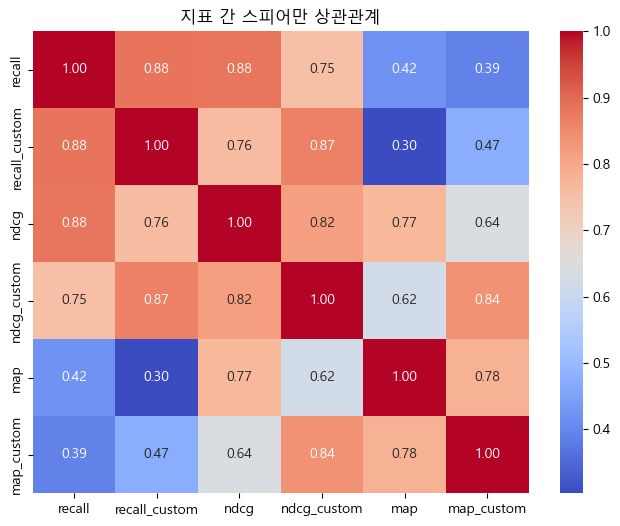

                 recall  recall_custom      ndcg  ndcg_custom       map  \
recall         1.000000       0.884327  0.880590     0.752055  0.422400   
recall_custom  0.884327       1.000000  0.759329     0.865121  0.303795   
ndcg           0.880590       0.759329  1.000000     0.817525  0.767445   
ndcg_custom    0.752055       0.865121  0.817525     1.000000  0.622537   
map            0.422400       0.303795  0.767445     0.622537  1.000000   
map_custom     0.392999       0.474314  0.643204     0.838055  0.780595   

               map_custom  
recall           0.392999  
recall_custom    0.474314  
ndcg             0.643204  
ndcg_custom      0.838055  
map              0.780595  
map_custom       1.000000  


In [103]:
metrics_cols = ['recall', 'recall_custom', 'ndcg', 'ndcg_custom', 'map', 'map_custom']
corr_matrix = filtered_result[metrics_cols].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("지표 간 스피어만 상관관계")
plt.show()

print(corr_matrix)

In [108]:
df = filtered_result.copy()

# 평균 점수 컬럼 계산
df['mean_score'] = df[['recall', 'map', 'ndcg']].mean(axis=1)
df['mean_score_custom'] = df[['recall_custom', 'map_custom', 'ndcg_custom']].mean(axis=1)

# 상위 50개 인덱스 추출
top50_base = df.sort_values(by='mean_score', ascending=False).head(50).index
top50_custom = df.sort_values(by='mean_score_custom', ascending=False).head(50).index

# 공통 인덱스
common_indices = set(top50_base).intersection(set(top50_custom))
common_count = len(common_indices)
ratio = common_count / 50 * 100  # 비율 계산

# 출력
print(f"공통된 상위 50개 조합 수: {common_count}개")
print(f"비율: {ratio:.2f}%")

공통된 상위 50개 조합 수: 11개
비율: 22.00%


# 5. 기존 + Custom 데이터셋 최적화
### 평가 결과
* Custom_Dataset의 recall 최고지표: 0.604839
* 기존 Dataset의 recall 최고지표: 0.732667
* 병합(기존 + Custom) Dataset의 recall 최고지표: 0.0.657440
### 시사점
* 병합 데이터셋의 recall 지표가 목표 값인 0.8 대비 낮음
* 모듈형(Modular) RAG 아키텍쳐 기반의 성능 고도화 필요


In [28]:
origin_dataset = pd.read_csv('../data/document/역도/generated_persona_dataset.csv')
custom_dataset = pd.read_csv('../data/document/역도/customDataset.csv')
merged_dataset = pd.concat([origin_dataset, custom_dataset], ignore_index=True)

In [22]:
merged_dataset = merged_dataset.drop(columns = ['reference_contexts_section'])
merged_dataset['reference_contexts'] = merged_dataset['reference_contexts'].apply(lambda x : eval(x))

columns = merged_dataset.columns[4:]
for column in columns:
    merged_dataset[column] = merged_dataset[column].apply(lambda x : eval(x))

In [24]:
optimization_result_merged = optimization(configs, merged_dataset)

100%|██████████| 516/516 [00:06<00:00, 80.41it/s] 


In [27]:
optimization_result_merged.sort_values(by=['recall', 'map', 'ndcg'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map
499,15,80,threshold,bm25_kiwi,NaN,NaN,0.3,0.386672,0.657440,0.328944
460,15,60,threshold,bm25_kiwi,NaN,NaN,0.3,0.408343,0.648512,0.358968
421,15,40,threshold,bm25_kiwi,NaN,NaN,0.3,0.434072,0.644048,0.395382
7,15,0,None,bm25_kiwi,NaN,NaN,NaN,0.443388,0.639583,0.409195
383,15,20,threshold,bm25_kiwi,NaN,NaN,0.5,0.443388,0.639583,0.409195
384,15,20,threshold,bm25_kiwi,NaN,NaN,0.7,0.443388,0.639583,0.409195
385,15,20,threshold,bm25_kiwi,NaN,NaN,0.9,0.443388,0.639583,0.409195
422,15,40,threshold,bm25_kiwi,NaN,NaN,0.5,0.443388,0.639583,0.409195
423,15,40,threshold,bm25_kiwi,NaN,NaN,0.7,0.443388,0.639583,0.409195
424,15,40,threshold,bm25_kiwi,NaN,NaN,0.9,0.443388,0.639583,0.409195
